In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import lightgbm
from sklearn.neural_network import MLPRegressor


2024-09-28 08:29:55.219272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 08:29:55.219446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 08:29:55.361298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
oni = pd.read_excel('../input/climate-indeices/ONI.xlsx')
enso = pd.read_excel('../input/climate-indeices/ENSO.xlsx')
#amo = pd.read_excel('../input/climate-indeices/AMO.xlsx')
nao = pd.read_excel('../input/climate-indeices/NAO.xlsx')
soi = pd.read_excel('../input/climate-indeices/SOI.xlsx')

In [4]:
oni=pd.melt(oni, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
enso=pd.melt(enso, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
#amo=pd.melt(amo, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
nao=pd.melt(nao, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
soi=pd.melt(soi, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])

In [5]:
climate=soi.merge( nao ,how='left', on= ['Year', 'month'],suffixes=('_s', '_n') ).merge(oni,how='left', on= ['Year', 'month']).merge(enso,how='left', on= ['Year', 'month'],suffixes=('_a', '_e'))#.merge(amo,how='left', on= ['Year', 'month'])
climate.head(2)

,Year,month,value_s,value_n,value_a,value_e
0,1979,01,0.2,-1.38,0.0,0.26
1,1979,02,0.2,-0.67,0.1,-0.25


In [6]:
climate=climate.rename(columns={'value_s':'soi' ,'value_n':'nao' , 'value_a':'amo', 'value_e':'enso', 'value':'oni'})
climate.dropna(inplace=True)

In [7]:
climate['soi30']=climate['soi'].shift(1)
climate['soi60']=climate['soi'].shift(2)
climate['soi90']=climate['soi'].shift(3)
climate['soi360']=climate['soi'].shift(12)

climate['nao30']=climate['nao'].shift(1)
climate['nao60']=climate['nao'].shift(2)
climate['nao90']=climate['nao'].shift(3)
climate['nao120']=climate['nao'].shift(4)
climate['nao150']=climate['nao'].shift(5)
climate['nao180']=climate['nao'].shift(6)
climate['nao270']=climate['nao'].shift(9)
climate['nao360']=climate['nao'].shift(12)

climate['amo30']=climate['amo'].shift(1)
climate['amo60']=climate['amo'].shift(2)
climate['amo90']=climate['amo'].shift(3)
climate['amo360']=climate['amo'].shift(12)

climate['enso30']=climate['enso'].shift(1)
climate['enso60']=climate['enso'].shift(2)
climate['enso90']=climate['enso'].shift(3)
climate['enso360']=climate['enso'].shift(12)

In [8]:
df = pd.read_csv('../input/amirkabirdam/dam12.csv')
df.head(2)

,DamId,DateRow,Torbin_out,TakhlieAbgir_out,Sarriz_out,TabKhir_out,Total_out,TotalMasraf_out,TakhlieRosob_out,Cheshme_out,NashtZehkesh_out,TakhlieKonandeTahtani_out,MasahatFeli_in,HajmMofid_in,HajmKol_in,SubractSarabPayab_in,ErtefPayab_in,ErtefaSarab_in,Asli_in,Total_in,Motefareghe_in,Barandegi_in,BareshBarf_in,AbMoadelBarf_in,TotalAbBarfVBaran_in,MinDarajehararat_in,MaxDarajehararat_in,Tabkhir_in,TabkhirBaEmalZarib_in,ShedatAftab_in,FesharJav_in,SoratBad_in,JahatBad_in,VazeHava_in,HajmSeilabMCM,DebiSeilabm3c,MaxSarRizDarZamanSeilab,HajmAbTakhlieAzSadBarayeSeil,HajmAbTakhlieAzSadBarayPishbini,DarajeHararat6_5,DarajeHararat12_5,DarajeHararat18_5,DarajeHararatKhosk6_5,DarajeHararatKhosk12_5,DarajeHararatKhosk18_5,DarajeHararatTar6_5,DarajeHararatTar12_5,DarajeHararatTar18_5,NamNesbi6_5,NamNesbi12_5,NamNesbi18_5,TolGeo,ArzGeo,MaxErtefaAzDarya,MinErtefaAzDarya,KafDaryache,GonjayeshKolMakhzan,GonjayeshMofidMakhzan
0,1,1966-05-11,1.63296,0.0,0.0,0.0,1.63296,0.22464,0,0,0,0,0.0,177.590,193.590,1607.00,155.31,1762.31,2.80800,2.80800,0,0.0,0.0,0.0,0.0,13.0,24.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.25563,35.252621,1765,1600,1595,183,177.3
1,1,1970-10-08,0.78624,0.0,0.0,0.0,0.78624,0.45792,0,0,0,0,0.0,101.726,117.726,1609.21,129.46,1738.67,0.28512,0.28512,0,0.0,0.0,0.0,0.0,15.0,27.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.25563,35.252621,1765,1600,1595,183,177.3


In [9]:
df['humidity']=df[['NamNesbi6_5', 'NamNesbi12_5','NamNesbi18_5']].mean(axis=1)
df['daraje']= df[['MinDarajehararat_in','MaxDarajehararat_in']].mean(axis=1)

In [10]:
df['DateRow'] = pd.to_datetime(df['DateRow'])
df = df.sort_values(by= 'DateRow')
#df = df[df['DateRow']>'2015']


In [11]:
target = 'Total_in'
features = ['Barandegi_in','TotalAbBarfVBaran_in','DebiSeilabm3c','daraje','VazeHava_in','SoratBad_in' ,'humidity']

df1= df[features + [target]]

In [12]:
cal=['Year','month','day_of_week','day_of_year']

df['Year'] = df['DateRow'].dt.year
df['month'] = df['DateRow'].dt.month
df['day_of_week'] = df['DateRow'].dt.dayofweek
df['day_of_year'] = df['DateRow'].dt.dayofyear
df.drop(columns=['DateRow'], inplace=True)

In [13]:
climate['month']=climate['month'].astype('int32')
df= climate.merge(df , how= 'inner' , on = ['Year', 'month'],suffixes=('_x', '_y'))

In [14]:
df.columns

Index(['Year', 'month', 'soi', 'nao', 'amo', 'enso', 'soi30', 'soi60', 'soi90',
       'soi360', 'nao30', 'nao60', 'nao90', 'nao120', 'nao150', 'nao180',
       'nao270', 'nao360', 'amo30', 'amo60', 'amo90', 'amo360', 'enso30',
       'enso60', 'enso90', 'enso360', 'DamId', 'Torbin_out',
       'TakhlieAbgir_out', 'Sarriz_out', 'TabKhir_out', 'Total_out',
       'TotalMasraf_out', 'TakhlieRosob_out', 'Cheshme_out',
       'NashtZehkesh_out', 'TakhlieKonandeTahtani_out', 'MasahatFeli_in',
       'HajmMofid_in', 'HajmKol_in', 'SubractSarabPayab_in', 'ErtefPayab_in',
       'ErtefaSarab_in', 'Asli_in', 'Total_in', 'Motefareghe_in',
       'Barandegi_in', 'BareshBarf_in', 'AbMoadelBarf_in',
       'TotalAbBarfVBaran_in', 'MinDarajehararat_in', 'MaxDarajehararat_in',
       'Tabkhir_in', 'TabkhirBaEmalZarib_in', 'ShedatAftab_in', 'FesharJav_in',
       'SoratBad_in', 'JahatBad_in', 'VazeHava_in', 'HajmSeilabMCM',
       'DebiSeilabm3c', 'MaxSarRizDarZamanSeilab',
       'HajmAbTakhlieAzSadB

In [15]:
cli=['soi', 'nao', 'amo', 'enso', 'soi30', 'soi60', 'soi90',
       'soi360', 'nao30', 'nao60', 'nao90', 'nao120', 'nao150', 'nao180',
       'nao270', 'nao360', 'amo30', 'amo60', 'amo90', 'amo360', 'enso30',
       'enso60', 'enso90', 'enso360','Year', 'month', 'day_of_week', 'day_of_year']

In [16]:
shift=[1,2,7,30,90,120,150,180,270,365]
temp=pd.DataFrame()
def create_shifted_dataframe(df, column_name, shift_period):
    shifted_column = df[column_name].shift(periods=shift_period)
    r_column_m= df[column_name].shift(periods=1).rolling(window=shift_period).mean()
    shift_df = pd.DataFrame({f"{column_name}_{shift_period}": shifted_column})
    roll_df = pd.DataFrame({f"{column_name}_{shift_period}": r_column_m})
    return (shift_df,roll_df)

for i in range (len (shift)):
    for j in range(len (df[features + [target]].columns)):
        temp[df1.columns[j]+'_rm_'+str(shift[i])],temp[df1.columns[j]+str(shift[i])] = (create_shifted_dataframe(df1,df1.columns[j], shift[i]))

final=pd.concat([df1,temp,df[cli]] , axis=1)       

/tmp/ipykernel_18/1393968192.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp[df1.columns[j]+'_rm_'+str(shift[i])],temp[df1.columns[j]+str(shift[i])] = (create_shifted_dataframe(df1,df1.columns[j], shift[i]))
/tmp/ipykernel_18/1393968192.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp[df1.columns[j]+'_rm_'+str(shift[i])],temp[df1.columns[j]+str(shift[i])] = (create_shifted_dataframe(df1,df1.columns[j], shift[i]))
/tmp/ipykernel_18/1393968192.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is u

In [17]:
final=final[final['Year']>=2015]

In [18]:

y=final[target]

x = final. drop(target,axis=1)

In [19]:
tscv = TimeSeriesSplit(n_splits = 10)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=6:
        
        model = xgb.XGBRegressor(n_estimators=440, learning_rate=0.01,  max_depth= 9, colsample_bytree= 0.6)
        
        model.fit(X_train,Y_train)

    # Predictions
        test_predict = model.predict(X_test)
        train_predict = model.predict(X_train)
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )





rmsetrain: 0.04253181036064294 rmsetest 0.3105187516422351
r2train: 0.9987154974289864 r2test: 0.9142774212926055


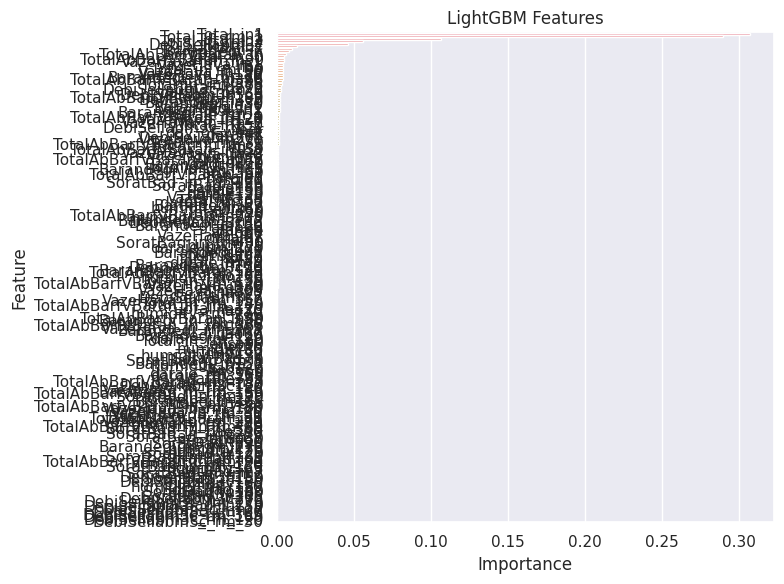

In [20]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="Importance", y="Feature", data=imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [21]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(30)
fe.head(30)

,Importance,Feature
22,0.307257,Total_in1
21,0.289764,Total_in_rm_1
38,0.106644,Total_in2
37,0.055840,Total_in_rm_2
2,0.046111,DebiSeilabm3c
54,0.013199,Total_in7
53,0.009709,Total_in_rm_7
0,0.007676,Barandegi_in
1,0.005950,TotalAbBarfVBaran_in
70,0.004952,Total_in30


In [22]:
tscv = TimeSeriesSplit(n_splits = 10)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=6:
        lgb = lightgbm.LGBMRegressor( n_estimators=410, num_leaves=31, learning_rate=0.01, colsample_bytree=0.85,verbose=0)

        lgb.fit(X_train, Y_train)

        test_predict = lgb.predict(X_test, num_iteration=lgb.best_iteration_)
        train_predict = lgb.predict(X_train, num_iteration=lgb.best_iteration_)

        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))

        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))

print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )


rmsetrain: 0.17224666817377388 rmsetest 0.2948126644609862
r2train: 0.9788501085680675 r2test: 0.9231969612405946


In [23]:

final.dropna(inplace=True, axis=0)
final.shape

(2899, 196)

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final)
scaled_df = pd.DataFrame(scaled_data, columns=final.columns)

final.reset_index(inplace=True ,drop=True)

In [25]:

y=scaled_df[target]

x = scaled_df. drop(columns =[ target ],axis=1)#,'index'

In [26]:
x.shape

(2899, 195)

In [27]:
y.shape

(2899,)

In [28]:
tscv = TimeSeriesSplit(n_splits = 10)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=6:
        
        mlp = MLPRegressor(hidden_layer_sizes=(83,15), activation='relu', solver='adam', max_iter=300,learning_rate='constant', early_stopping=True,alpha=  0.01)

        mlp.fit(X_train, Y_train)

        test_predict = mlp.predict(X_test)
        train_predict = mlp.predict(X_train)
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )


## ی سوال: اینجا که ما شافل نداریم. درسته که توی ارزیابی مقادیر تغییر می کنه؟؟ در صورتی که شرایط کاملا یکسان و بدون تغییر هست.؟؟؟

rmsetrain: 0.017181979314169905 rmsetest 0.030668508503131194
r2train: 0.9610109374575474 r2test: 0.8574679691782059
